In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.utils import shuffle
from catboost import CatBoostClassifier

<a id='top_destination'></a> 
#     Customer Retention Model  
##  [1. Open and Prepare Data](#the_destination_1)
   ###      [1.1 Inspect Data](#the_destination_1_1)
   ###      [1.2 Prepare Data](#the_destination_1_2)
   ###      [1.3 Prepare Features](#the_destination_1_3)
   ###      [1.4 Prepare Target](#the_destination_1_4)
   ###     *[1.5 Summary and Work Plan](#the_destination_1_5)
   
   

##  [2. Baseline Model](#the_destination_2)
   ###      [2.1 Split Data](#the_destination_2_1)
   ###      [2.2 Train Base Line Model](#the_destination_2_2)

  
##  [3. Improve the quality of the model](#the_destination_3)
   ###      [3.1 CatboostRegressor Model](#the_destination_3_1)
   ###      [3.2 Dense Neural Network Model](#the_destination_3_2)
   


##  [4. Conclusion](#the_destination_4)
   ###      [4.1 Best Model with Test Set](#the_destination_4_1)
   ###      *[4.2 Solution Report](#the_destination_4_2)

<a id='the_destination_1'></a>
##  1. Open and Prepare Data.  
[back to Table of Content](#top_destination)

<a id='the_destination_1_1'></a>
###  1.1 Inspect Data

In [2]:
try:
    df_contract = pd.read_csv('data/contract.csv')
    df_internet = pd.read_csv('data/internet.csv')
    df_personal = pd.read_csv('data/personal.csv')
    df_phone = pd.read_csv('data/phone.csv')
except:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv')


In [3]:
display(df_contract.head())
display(df_internet.head())
display(df_personal.head())
display(df_phone.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [4]:
df_contract['EndDate'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64

In [5]:
display(df_contract.info())
display(df_internet.info())
display(df_personal.info())
display(df_phone.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


None

<a id='the_destination_1_2'></a>
### 1.2 Prepare Data

In [6]:
df = df_contract.set_index('customerID').join(df_internet.set_index('customerID')).join(df_personal.set_index('customerID')).join(df_phone.set_index('customerID'))
df = df.reset_index()
display(df.head())
display(df.info())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
MultipleLines       6361 non-null object
dtypes: float64(1), int64(1), object(18)
memory usage: 1.1+ MB


None

In [7]:
df = df.fillna('NA')
df.columns = df.columns.str.lower()
display(df.head())
display(df.info())

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NA
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NA
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
customerid          7043 non-null object
begindate           7043 non-null object
enddate             7043 non-null object
type                7043 non-null object
paperlessbilling    7043 non-null object
paymentmethod       7043 non-null object
monthlycharges      7043 non-null float64
totalcharges        7043 non-null object
internetservice     7043 non-null object
onlinesecurity      7043 non-null object
onlinebackup        7043 non-null object
deviceprotection    7043 non-null object
techsupport         7043 non-null object
streamingtv         7043 non-null object
streamingmovies     7043 non-null object
gender              7043 non-null object
seniorcitizen       7043 non-null int64
partner             7043 non-null object
dependents          7043 non-null object
multiplelines       7043 non-null object
dtypes: float64(1), int64(1), object(18)
memory usage: 1.1+ MB


None

In [8]:
df['totalcharges'] = df['totalcharges'].replace([" "], 0)
df['totalcharges'] = pd.to_numeric(df['totalcharges'])
df['seniorcitizen'] = df['seniorcitizen'].astype('int')
display(df['totalcharges'].describe())
display(df['seniorcitizen'].value_counts())

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: totalcharges, dtype: float64

0    5901
1    1142
Name: seniorcitizen, dtype: int64

In [9]:
df['internetservice'].value_counts()

Fiber optic    3096
DSL            2421
NA             1526
Name: internetservice, dtype: int64

<a id='the_destination_1_3'></a>
### 1.3 Prepare Features

- We will add a new feature 'longevity'.
- We will label encode catagorical features. 

In [10]:
# we will add a feature 'longevity' based on 'begindata' and 'enddata' while setting enddate to 2020-02-01 for 'No'
df_contract['EndDate'] = df_contract['EndDate'].replace(['No'],'2020-02-01 00:00:00')
df_contract['EndDate']= pd.to_datetime(pd.to_datetime(df_contract['EndDate']).dt.date)
df_contract['BeginDate']= pd.to_datetime(df_contract['BeginDate'])
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65


In [11]:
df['longevity'] = (df_contract['EndDate'] - df_contract['BeginDate']).dt.days.astype('int')
display(df.head())

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines,longevity
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,No,Female,0,Yes,No,NA,31
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,...,Yes,No,No,No,Male,0,No,No,No,1036
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,No,Male,0,No,No,No,61
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,...,Yes,Yes,No,No,Male,0,No,No,NA,1371
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,No,No,No,Female,0,No,No,No,61


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerid          7043 non-null object
begindate           7043 non-null object
enddate             7043 non-null object
type                7043 non-null object
paperlessbilling    7043 non-null object
paymentmethod       7043 non-null object
monthlycharges      7043 non-null float64
totalcharges        7043 non-null float64
internetservice     7043 non-null object
onlinesecurity      7043 non-null object
onlinebackup        7043 non-null object
deviceprotection    7043 non-null object
techsupport         7043 non-null object
streamingtv         7043 non-null object
streamingmovies     7043 non-null object
gender              7043 non-null object
seniorcitizen       7043 non-null int64
partner             7043 non-null object
dependents          7043 non-null object
multiplelines       7043 non-null object
longevity           7043 non-null int64
dtypes: float64(2), int64(2), ob

In [13]:
#we will use label encoding to convert all the catagorical features.
categorical_cols = df.columns.drop(['customerid', 'begindate', 
                                    'enddate', 'monthlycharges', 
                                    'totalcharges', 'seniorcitizen', 'longevity'])
encoder = OrdinalEncoder()
df[categorical_cols] = encoder.fit_transform(df[categorical_cols])
df.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,gender,seniorcitizen,partner,dependents,multiplelines,longevity
0,7590-VHVEG,2020-01-01,No,0.0,1.0,2.0,29.85,29.85,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0,1.0,0.0,0.0,31
1,5575-GNVDE,2017-04-01,No,1.0,0.0,3.0,56.95,1889.50,0.0,2.0,...,2.0,1.0,1.0,1.0,1.0,0,0.0,0.0,1.0,1036
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,0.0,1.0,3.0,53.85,108.15,0.0,2.0,...,1.0,1.0,1.0,1.0,1.0,0,0.0,0.0,1.0,61
3,7795-CFOCW,2016-05-01,No,1.0,0.0,0.0,42.30,1840.75,0.0,2.0,...,2.0,2.0,1.0,1.0,1.0,0,0.0,0.0,0.0,1371
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,0.0,1.0,2.0,70.70,151.65,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0,0.0,0.0,1.0,61


In [14]:
df['begindate'] = pd.to_datetime(df['begindate']).astype('int')
df['customerid'] = pd.to_datetime(df['begindate']).astype('int')
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerid          7043 non-null int64
begindate           7043 non-null int64
enddate             7043 non-null object
type                7043 non-null float64
paperlessbilling    7043 non-null float64
paymentmethod       7043 non-null float64
monthlycharges      7043 non-null float64
totalcharges        7043 non-null float64
internetservice     7043 non-null float64
onlinesecurity      7043 non-null float64
onlinebackup        7043 non-null float64
deviceprotection    7043 non-null float64
techsupport         7043 non-null float64
streamingtv         7043 non-null float64
streamingmovies     7043 non-null float64
gender              7043 non-null float64
seniorcitizen       7043 non-null int64
partner             7043 non-null float64
dependents          7043 non-null float64
multiplelines       7043 non-null float64
longevity           7043 non-null int64
dtypes: float64(16),

None

- We successfully converted all the features.

<a id='the_destination_1_4'></a>
### 1.4 Prepare Target

In [15]:
df['enddate'] = df['enddate'].apply(lambda x: 0 if x == 'No' else 1)
display(df['enddate'].value_counts())
print('Percetage of customers who stay', round((df[df['enddate']==0].shape[0])/df.shape[0]*100, 2), '%')

0    5174
1    1869
Name: enddate, dtype: int64

Percetage of customers who stay 73.46 %


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerid          7043 non-null int64
begindate           7043 non-null int64
enddate             7043 non-null int64
type                7043 non-null float64
paperlessbilling    7043 non-null float64
paymentmethod       7043 non-null float64
monthlycharges      7043 non-null float64
totalcharges        7043 non-null float64
internetservice     7043 non-null float64
onlinesecurity      7043 non-null float64
onlinebackup        7043 non-null float64
deviceprotection    7043 non-null float64
techsupport         7043 non-null float64
streamingtv         7043 non-null float64
streamingmovies     7043 non-null float64
gender              7043 non-null float64
seniorcitizen       7043 non-null int64
partner             7043 non-null float64
dependents          7043 non-null float64
multiplelines       7043 non-null float64
longevity           7043 non-null int64
dtypes: float64(16), 

<a id='the_destination_1_5'></a>
### 1.5 Summary and Work Plan

#### Summary
- 1. We combined dataframes to a unified dataframe.
- 2. We identify the target column 'enddate' and the feature columns.
- 3. We added a 'longevity' column and converted target column and all feature columns for next step.
- 4. We chose label encoding for catagorical features

#### Work Plan
##### Step 1. 
     1.1 We found there are mismatch in numbers of users in different dataframe, we first join all four data sets, then we fill them with a value 'NA', so when we encode the features, the customers who did not use internet or phone service will be recognized by the model.
     1.2 When we encode features, we use label encoding on only catagorical features because we want to keep the numerical properties of some of the features like 'longevity', 'monthlycharges' and so on.
    
##### Step 2. 
     2.1 We will split the data, normalize the data in training set and validation set. 
     2.2 We will use a logistic regression model as a dummy model for comparison.
     2.3 The evaluation metric will be AUC-ROC and we will use accuracy as a additional metric to evaluate the model.
     2.4 We found there is a class imbalance in target, so we will upsample the data and train models to both original data and upsampled data to compare.
     2.5 Cross validation will be used for better accuracy.
    
##### Step 3.
     3.1 We will train a catboost classifier model and evaluate the model with AUC-ROC and accuracy metrics.
     3.2 We will also implement dense neural network to our model with 'sigmoid' activation and one output.

<a id='the_destination_2'></a>
##  2. Baseline model.  
[back to Table of Content](#top_destination)

<a id='the_destination_2_1'></a>
### 2.1 Split the data

In [17]:
#First, we need to split processed data 'df' into 'Training Set'(60%), 'Validation Set'(20%) and 'Test Set'(20%)
df_train, df_remain = train_test_split(df, test_size=0.40, random_state=12345)
df_valid, df_test = train_test_split(df_remain, test_size=0.50, random_state=12345)

display(df_train['enddate'].value_counts())
display(df_valid['enddate'].value_counts())
display(df_test['enddate'].value_counts())


0    3124
1    1101
Name: enddate, dtype: int64

0    1027
1     382
Name: enddate, dtype: int64

0    1023
1     386
Name: enddate, dtype: int64

In [18]:
#Second, we will standardize the traning set and validation set.
scaler = StandardScaler()
scaler.fit(df_train)
df_train = pd.DataFrame(scaler.transform(df_train), columns=df_train.columns, index=df_train.index)
df_valid = pd.DataFrame(scaler.transform(df_valid), columns=df_valid.columns, index=df_valid.index)
df_test = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns, index=df_test.index)

display(df_train.info())
display(df_valid.info())
display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4225 entries, 836 to 4578
Data columns (total 21 columns):
customerid          4225 non-null float64
begindate           4225 non-null float64
enddate             4225 non-null float64
type                4225 non-null float64
paperlessbilling    4225 non-null float64
paymentmethod       4225 non-null float64
monthlycharges      4225 non-null float64
totalcharges        4225 non-null float64
internetservice     4225 non-null float64
onlinesecurity      4225 non-null float64
onlinebackup        4225 non-null float64
deviceprotection    4225 non-null float64
techsupport         4225 non-null float64
streamingtv         4225 non-null float64
streamingmovies     4225 non-null float64
gender              4225 non-null float64
seniorcitizen       4225 non-null float64
partner             4225 non-null float64
dependents          4225 non-null float64
multiplelines       4225 non-null float64
longevity           4225 non-null float64
dtypes: f

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1409 entries, 4164 to 1945
Data columns (total 21 columns):
customerid          1409 non-null float64
begindate           1409 non-null float64
enddate             1409 non-null float64
type                1409 non-null float64
paperlessbilling    1409 non-null float64
paymentmethod       1409 non-null float64
monthlycharges      1409 non-null float64
totalcharges        1409 non-null float64
internetservice     1409 non-null float64
onlinesecurity      1409 non-null float64
onlinebackup        1409 non-null float64
deviceprotection    1409 non-null float64
techsupport         1409 non-null float64
streamingtv         1409 non-null float64
streamingmovies     1409 non-null float64
gender              1409 non-null float64
seniorcitizen       1409 non-null float64
partner             1409 non-null float64
dependents          1409 non-null float64
multiplelines       1409 non-null float64
longevity           1409 non-null float64
dtypes: 

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1409 entries, 6085 to 2596
Data columns (total 21 columns):
customerid          1409 non-null float64
begindate           1409 non-null float64
enddate             1409 non-null float64
type                1409 non-null float64
paperlessbilling    1409 non-null float64
paymentmethod       1409 non-null float64
monthlycharges      1409 non-null float64
totalcharges        1409 non-null float64
internetservice     1409 non-null float64
onlinesecurity      1409 non-null float64
onlinebackup        1409 non-null float64
deviceprotection    1409 non-null float64
techsupport         1409 non-null float64
streamingtv         1409 non-null float64
streamingmovies     1409 non-null float64
gender              1409 non-null float64
seniorcitizen       1409 non-null float64
partner             1409 non-null float64
dependents          1409 non-null float64
multiplelines       1409 non-null float64
longevity           1409 non-null float64
dtypes: 

None

<a id='the_destination_2_2'></a>
### 2.2 Train the baseline model

In [19]:
train_features = df_train.drop(['customerid','begindate', 'enddate'], axis=1)
train_target = df_train['enddate'].astype('int')
valid_features = df_valid.drop(['customerid','begindate', 'enddate'], axis=1)
valid_target = df_valid['enddate'].astype('int')

In [20]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4225 entries, 836 to 4578
Data columns (total 18 columns):
type                4225 non-null float64
paperlessbilling    4225 non-null float64
paymentmethod       4225 non-null float64
monthlycharges      4225 non-null float64
totalcharges        4225 non-null float64
internetservice     4225 non-null float64
onlinesecurity      4225 non-null float64
onlinebackup        4225 non-null float64
deviceprotection    4225 non-null float64
techsupport         4225 non-null float64
streamingtv         4225 non-null float64
streamingmovies     4225 non-null float64
gender              4225 non-null float64
seniorcitizen       4225 non-null float64
partner             4225 non-null float64
dependents          4225 non-null float64
multiplelines       4225 non-null float64
longevity           4225 non-null float64
dtypes: float64(18)
memory usage: 627.1 KB


In [21]:
# we will not take class imbalance into condiseration by setting class_weight to 'balanced'.
model_0 = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_0.fit(train_features, train_target)
predicted_proba_0 = model_0.predict_proba(valid_features)[:, 1]
predicted_0 = model_0.predict(valid_features)
print("ROU-AUC for baseline model: {:.3f} "
      .format(roc_auc_score(valid_target, predicted_proba_0)))

print('Accuracy for baseline model: {:.2f} %'
      .format(accuracy_score(valid_target, predicted_0)*100))

ROU-AUC for baseline model: 0.846 
Accuracy for baseline model: 74.73 %


In [22]:
# We can upsample the positive class in Training Set by 3 times to balance the class.
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

train_features, train_target = upsample(train_features, train_target, 3)

In [23]:
# we will now take class imbalance into condiseration by setting class_weight to 'balanced'.
model_1 = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model_1.fit(train_features, train_target)
predicted_proba_1 = model_1.predict_proba(valid_features)[:, 1]
predicted_1 = model_1.predict(valid_features)

print("ROU-AUC for first model: {:.3f}"
      .format(roc_auc_score(valid_target, predicted_proba_1)))
print('Accuracy for first model: {:.2f} %'
      .format(accuracy_score(valid_target, predicted_1)*100))

ROU-AUC for first model: 0.846
Accuracy for first model: 74.80 %


In [24]:
#Define function to calculate roc_auc
def roc_auc(target, prediction_proba):
    
    return roc_auc_score(target, prediction_proba)

#Use cross validation to verify quality of models.
def CrossValid(model):
    roc_auc_score = make_scorer(roc_auc)
    scores = cross_val_score(model, train_features, train_target, cv=5, scoring = roc_auc_score)
    return scores.mean()


In [25]:
print(round(CrossValid(model_1),2))


0.77


<a id='the_destination_3'></a>
##  3. Improve the quality of the model.  
[back to Table of Content](#top_destination)

<a id='the_destination_3_1'></a>
### 3.1 CatBoost Regressor Model

In [26]:
%%time
# CatBoostRegressor quality of prediction and runtime. 
model_2 = CatBoostClassifier(loss_function="CrossEntropy", iterations=200, random_seed=12345)
model_2.fit(train_features, train_target, verbose=20)

0:	learn: 0.6798378	total: 54.3ms	remaining: 10.8s
20:	learn: 0.5342175	total: 104ms	remaining: 883ms
40:	learn: 0.4792001	total: 171ms	remaining: 664ms
60:	learn: 0.4523086	total: 239ms	remaining: 545ms
80:	learn: 0.4369115	total: 308ms	remaining: 452ms
100:	learn: 0.4244610	total: 368ms	remaining: 360ms
120:	learn: 0.4126280	total: 424ms	remaining: 277ms
140:	learn: 0.4029896	total: 469ms	remaining: 196ms
160:	learn: 0.3944179	total: 514ms	remaining: 124ms
180:	learn: 0.3870157	total: 557ms	remaining: 58.5ms
199:	learn: 0.3803134	total: 598ms	remaining: 0us
CPU times: user 3.11 s, sys: 342 ms, total: 3.46 s
Wall time: 631 ms


In [27]:
%%time
prediction_2 = model_2.predict(valid_features)

CPU times: user 4.53 ms, sys: 1.61 ms, total: 6.14 ms
Wall time: 2.36 ms


In [28]:
print(round(CrossValid(model_2),2))

0:	learn: 0.6794419	total: 2.38ms	remaining: 475ms
1:	learn: 0.6664181	total: 4.63ms	remaining: 459ms
2:	learn: 0.6531721	total: 6.72ms	remaining: 441ms
3:	learn: 0.6423882	total: 9.2ms	remaining: 451ms
4:	learn: 0.6311159	total: 11.7ms	remaining: 455ms
5:	learn: 0.6221712	total: 13.9ms	remaining: 450ms
6:	learn: 0.6117832	total: 16.5ms	remaining: 455ms
7:	learn: 0.6021650	total: 19ms	remaining: 455ms
8:	learn: 0.5944783	total: 21.4ms	remaining: 455ms
9:	learn: 0.5869876	total: 24ms	remaining: 456ms
10:	learn: 0.5798417	total: 26.6ms	remaining: 458ms
11:	learn: 0.5725349	total: 29.1ms	remaining: 456ms
12:	learn: 0.5675349	total: 31.1ms	remaining: 448ms
13:	learn: 0.5613617	total: 33.5ms	remaining: 445ms
14:	learn: 0.5550525	total: 35.8ms	remaining: 442ms
15:	learn: 0.5492408	total: 38.1ms	remaining: 439ms
16:	learn: 0.5437635	total: 40.7ms	remaining: 438ms
17:	learn: 0.5391489	total: 42.9ms	remaining: 434ms
18:	learn: 0.5333743	total: 45ms	remaining: 429ms
19:	learn: 0.5291599	total: 4

In [29]:
predicted_proba_2 = model_2.predict_proba(valid_features)[:, 1]
predicted_2 = model_2.predict(valid_features)

print("ROC-AUC on validation set for second model: {:.3f}"
      .format(roc_auc_score(valid_target, predicted_proba_2)))

print('Accuracy for second model: {:.2f} %'.format(accuracy_score(valid_target, predicted_2)*100))

ROC-AUC on validation set for second model: 0.871
Accuracy for second model: 77.29 %


In [30]:
%%time
# CatBoostRegressor quality of prediction and runtime. 
model_3 = CatBoostClassifier(loss_function="Logloss", depth=5, iterations=250, random_seed=12345)
model_3.fit(train_features, train_target, verbose=20)


Learning rate set to 0.081291
0:	learn: 0.6584223	total: 2.64ms	remaining: 658ms
20:	learn: 0.4648445	total: 47.2ms	remaining: 515ms
40:	learn: 0.4319422	total: 86.1ms	remaining: 439ms
60:	learn: 0.4108546	total: 126ms	remaining: 391ms
80:	learn: 0.3961432	total: 172ms	remaining: 360ms
100:	learn: 0.3832420	total: 224ms	remaining: 331ms
120:	learn: 0.3691214	total: 266ms	remaining: 284ms
140:	learn: 0.3548081	total: 309ms	remaining: 239ms
160:	learn: 0.3401221	total: 355ms	remaining: 196ms
180:	learn: 0.3274784	total: 401ms	remaining: 153ms
200:	learn: 0.3150213	total: 445ms	remaining: 108ms
220:	learn: 0.3015787	total: 486ms	remaining: 63.8ms
240:	learn: 0.2925248	total: 526ms	remaining: 19.6ms
249:	learn: 0.2882800	total: 543ms	remaining: 0us
CPU times: user 2.85 s, sys: 172 ms, total: 3.02 s
Wall time: 573 ms


In [31]:
print(round(CrossValid(model_3),2))

Learning rate set to 0.073899
0:	learn: 0.6604539	total: 2.11ms	remaining: 526ms
1:	learn: 0.6337532	total: 4.04ms	remaining: 501ms
2:	learn: 0.6097591	total: 5.9ms	remaining: 486ms
3:	learn: 0.5905278	total: 7.72ms	remaining: 475ms
4:	learn: 0.5722092	total: 9.72ms	remaining: 476ms
5:	learn: 0.5590280	total: 11.6ms	remaining: 471ms
6:	learn: 0.5465024	total: 13.4ms	remaining: 465ms
7:	learn: 0.5366611	total: 15.4ms	remaining: 466ms
8:	learn: 0.5285838	total: 17.2ms	remaining: 462ms
9:	learn: 0.5202424	total: 19ms	remaining: 456ms
10:	learn: 0.5138715	total: 20.8ms	remaining: 453ms
11:	learn: 0.5074237	total: 22.6ms	remaining: 448ms
12:	learn: 0.5025760	total: 24.4ms	remaining: 445ms
13:	learn: 0.4968150	total: 26.3ms	remaining: 443ms
14:	learn: 0.4932248	total: 27.9ms	remaining: 437ms
15:	learn: 0.4870474	total: 29.7ms	remaining: 435ms
16:	learn: 0.4824227	total: 31.6ms	remaining: 433ms
17:	learn: 0.4791892	total: 33.7ms	remaining: 434ms
18:	learn: 0.4741748	total: 35.9ms	remaining: 4

In [32]:
predicted_proba_3 = model_3.predict_proba(valid_features)[:, 1]
predicted_3 = model_3.predict(valid_features)

print("ROC-AUC on validation set for third model: {:.3f} "
      .format(roc_auc_score(valid_target, predicted_proba_3)))

print('Accuracy for third model: {:.2f} %'.format(accuracy_score(valid_target, predicted_3)*100))

ROC-AUC on validation set for third model: 0.896 
Accuracy for third model: 80.91 %


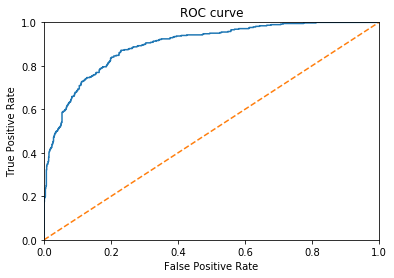

In [33]:
auc_roc = roc_auc_score(valid_target, predicted_proba_3)

fpr, tpr, thresholds = roc_curve(valid_target, predicted_proba_3)

plt.figure()

plt.plot(fpr, tpr)


# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

<a id='the_destination_3_2'></a>
### 3.2 Dense Neural Network Model

In [34]:
model_4 = keras.models.Sequential()
model_4.add(keras.layers.Dense(units=32, input_dim=train_features.shape[1], activation='relu'))
model_4.add(keras.layers.Dense(units=10, activation='relu'))
model_4.add(keras.layers.Dense(units=1, activation='sigmoid'))

optimizer=SGD()
model_4.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])

model_4.fit(train_features, train_target, epochs=8, verbose=2,
          validation_data=(valid_features, valid_target))

Epoch 1/8
201/201 - 1s - loss: 0.6042 - acc: 0.6687 - val_loss: 0.5615 - val_acc: 0.6969
Epoch 2/8
201/201 - 0s - loss: 0.5336 - acc: 0.7391 - val_loss: 0.5292 - val_acc: 0.7260
Epoch 3/8
201/201 - 0s - loss: 0.5082 - acc: 0.7520 - val_loss: 0.5236 - val_acc: 0.7310
Epoch 4/8
201/201 - 0s - loss: 0.4977 - acc: 0.7565 - val_loss: 0.5125 - val_acc: 0.7388
Epoch 5/8
201/201 - 0s - loss: 0.4921 - acc: 0.7602 - val_loss: 0.5083 - val_acc: 0.7431
Epoch 6/8
201/201 - 0s - loss: 0.4883 - acc: 0.7613 - val_loss: 0.5031 - val_acc: 0.7466
Epoch 7/8
201/201 - 0s - loss: 0.4852 - acc: 0.7624 - val_loss: 0.4975 - val_acc: 0.7466
Epoch 8/8
201/201 - 0s - loss: 0.4830 - acc: 0.7666 - val_loss: 0.4990 - val_acc: 0.7480


In [35]:
predicted_proba_4 = model_4.predict_proba(valid_features)
predicted_4 = model_4.predict(valid_features)
_, valid_acc_4 = model_4.evaluate(valid_features, valid_target, verbose=0)

print("ROC-AUC on validation set for dense neural network model: {:.3f} "
      .format(roc_auc_score(valid_target, predicted_proba_4)))

print('Accuracy for dense neural network model: {:.2f} %'.format(valid_acc_4*100))

ROC-AUC on validation set for dense neural network model: 0.847 
Accuracy for dense neural network model: 74.80 %


In [36]:
model_5 = keras.models.Sequential()
model_5.add(keras.layers.Dense(units=24, input_dim=train_features.shape[1], activation='relu'))
model_5.add(keras.layers.Dense(units=24, activation='relu'))
model_5.add(keras.layers.Dense(units=16, activation='sigmoid'))
model_5.add(keras.layers.Dense(units=10, activation='sigmoid'))
model_5.add(keras.layers.Dense(units=6, activation='sigmoid'))
model_5.add(keras.layers.Dense(units=2, activation='relu'))
model_5.add(keras.layers.Dense(units=1, activation='sigmoid'))

optimizer = Adam(0.00125)
model_5.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['acc'])

model_5.fit(train_features, train_target, epochs=15, verbose=2,
          validation_data=(valid_features, valid_target))

Epoch 1/15
201/201 - 1s - loss: 0.6679 - acc: 0.6451 - val_loss: 0.6997 - val_acc: 0.6764
Epoch 2/15
201/201 - 0s - loss: 0.5970 - acc: 0.7693 - val_loss: 0.6446 - val_acc: 0.7764
Epoch 3/15
201/201 - 0s - loss: 0.5614 - acc: 0.7716 - val_loss: 0.6193 - val_acc: 0.7771
Epoch 4/15
201/201 - 0s - loss: 0.5400 - acc: 0.7766 - val_loss: 0.6096 - val_acc: 0.7658
Epoch 5/15
201/201 - 0s - loss: 0.5255 - acc: 0.7783 - val_loss: 0.5723 - val_acc: 0.7835
Epoch 6/15
201/201 - 0s - loss: 0.5144 - acc: 0.7811 - val_loss: 0.5779 - val_acc: 0.7672
Epoch 7/15
201/201 - 0s - loss: 0.5050 - acc: 0.7814 - val_loss: 0.5577 - val_acc: 0.7693
Epoch 8/15
201/201 - 0s - loss: 0.4974 - acc: 0.7851 - val_loss: 0.5711 - val_acc: 0.7594
Epoch 9/15
201/201 - 0s - loss: 0.4895 - acc: 0.7889 - val_loss: 0.5752 - val_acc: 0.7466
Epoch 10/15
201/201 - 0s - loss: 0.4846 - acc: 0.7899 - val_loss: 0.5345 - val_acc: 0.7686
Epoch 11/15
201/201 - 0s - loss: 0.4782 - acc: 0.7903 - val_loss: 0.5149 - val_acc: 0.7729
Epoch 12

In [37]:
predicted_proba_5 = model_5.predict_proba(valid_features)
predicted_5 = model_5.predict(valid_features)
_, valid_acc_5 = model_5.evaluate(valid_features, valid_target, verbose=0)

print("ROC-AUC on validation set for dense neural network model: {:.3f}"
      .format(roc_auc_score(valid_target, predicted_proba_5)))

print('Accuracy for dense neural network model: {:.2f} %'.format(valid_acc_5*100))

ROC-AUC on validation set for dense neural network model: 0.842
Accuracy for dense neural network model: 76.65 %


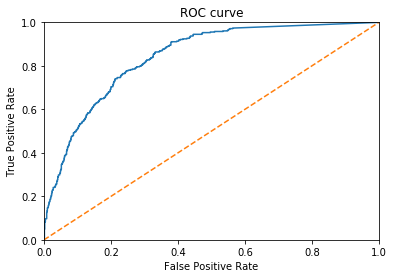

In [38]:
auc_roc = roc_auc_score(valid_target, predicted_proba_5)

fpr, tpr, thresholds = roc_curve(valid_target, predicted_proba_5)

plt.figure()

plt.plot(fpr, tpr)


# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

<a id='the_destination_4'></a>
##  4. Conclusion.  
[back to Table of Content](#top_destination)

#### After comparing three models:
     Baseline Model( Model_1), 
     Improved CatBoost Regressor Model(Model_3),
     Dense Neural Network Model(Model_5).
#### We are using evaluation metrics ROC-AUC score and Accuracy Score on the test set on the best model.

<a id='the_destination_4_1'></a>
### 4.1 Best Model with Test Set

In [39]:
test_features = df_test.drop(['customerid','begindate', 'enddate'], axis=1)
test_target = df_test['enddate'].astype('int')

In [40]:
#The best model in our case is catboost classifier model, we will evaluate the model on Test Set.
predicted_proba_test_3 = model_3.predict_proba(test_features)[:, 1]
predicted_test_3 = model_3.predict(test_features)

print("ROC-AUC on test set for best model: {:.3f} "
      .format(roc_auc_score(test_target, predicted_proba_test_3)))

print('Accuracy on test set for best model: {:.2f} %'.format(accuracy_score(test_target, predicted_test_3)*100))

ROC-AUC on test set for best model: 0.881 
Accuracy on test set for best model: 80.70 %


<a id='the_destination_4_2'></a>
### 4.2 *Solution Report

1. We followed the plan strictly and we performed all three steps including data processing, baseline model training and validaion, two improved models comparision. we did not skip any steps in the plan as those are necessary steps to train a better model.


2. There are several difficulties I encountered:
 1. Prepare data as features and target before training. I had to look up different encoding technique and tried different methods until I settled with the one that is most reasonable in our case;
 
 2. Selecting features for model training. I tried different combination of features to find the best evaluation metrics of the models;
 
 3. Using ROC-AUC metrics in different models. The way to calculate ROC-AUC metric is different so I had to read more informaiton about this metric and try to implement the correct codes to it;
 
 4. Deciding the best model to achieve best possible score. There are so many machine learnig models, I had to compare my work to lots of examples online and tried tuning parameters in two different kinds of models. 
 
 
3. Key steps to solve this problem are following:
 1. Process data so machine learning models can use data directly, we upsampled minority in target;
 
 2. Train and validate baseline model after normalization of the data;
 
 3. Compare two types of improved models and tuned parameters to find the best model;
 
 4. Verify the best model with test set using ROC-AUC score and accuracy score.
 
 
4. Here is how we find the best model and a summary of the best model:
 1. On the baseline model, we tried to upsample the minority in training target and it improves our model;
 
 2. Catboost Classifier and Dense neural network models achieved good score in both ROC-AUC and Accuracy metrics;
 
 3. The best model is the Catboost Classifier model with ROC-AUC score 0.881 on the test set it is also very good in accuracy at 80.70%;
 
 4. We realize when the dataset is relatively small with not many features, the regular logistic regression model will be sufficient enough. However, when the volumn of data increases to a different magnitude, the neural network model will have the biggest advantage. 

[back to Table of Content](#top_destination)